In [136]:
#!/usr/bin/env python3
#import your libraries
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import time
import warnings
warnings.filterwarnings("ignore")
from catboost import CatBoostClassifier, Pool
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import binarize
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier


In [2]:
train_transaction = pd.read_csv('/Users/krahman/work/fraud_detection/data/train_transaction.csv')
train_identity = pd.read_csv('/Users/krahman/work/fraud_detection/data/train_identity.csv')
# merging dataframes 
df_raw = train_transaction.merge(train_identity, on='TransactionID', how='left')
df_train = df_raw.copy()

In [ ]:
# list(df_train.columns)

In [ ]:
# train_transaction.head() # KEEP

In [ ]:
# train_identity.head() # KEEP

In [ ]:
# train_transaction.info(); # KEEP

In [ ]:
# train_identity.info(); # KEEP

#### Data Quality Check

In [ ]:
# list_null = df_train.isnull().any()
# df_null = pd.DataFrame(list_null).reset_index()
# df_null

In [ ]:
# df_train.loc[:,df_train.isnull().any()]['id_34'].unique()

In [ ]:
# KEEP
# train_transaction_sum = train_transaction.duplicated().sum()
# train_identity_sum = train_identity.duplicated().sum()
# columns = train_transaction.columns
# print('Train transaction duplicates: {}\nTrain identity duplicates: {} \n'.format(train_transaction_sum, train_identity_sum))
# # print('Train feature columns:\n', list(columns))

In [ ]:
# df_train.isnull().any() # KEEP

In [ ]:
# df_train.info() # KEEP

In [ ]:
# df_train.dtypes # KEEP

#### EDA

In [ ]:
# How many transactions are in the dataset?
# df_train.shape # KEEP

In [ ]:
# What is the fraud rate of the data set?
# fraud_rate = df_train.isFraud.value_counts() / 590540
# fraud_rate  # KEEP

In [ ]:
# What is the statistical overview of the data set?
# df_train.describe() # KEEP

In [ ]:
# fraud_summary = df_train.groupby('isFraud')
# fraud_summary.mean()

In [ ]:
# fraud_summary.mean().to_csv('/Users/krahman/work/fraud_detection/saved_files/fraud_groupby.csv')

In [ ]:
# df_train.isnull().any()

### Assigning columns to specific lists (cat, num, date, etc.)

In [3]:
# dropping columns with more than 50% missing data
length_df = df_train.shape[0]/2
list_temp = []
for val in df_train.columns:
    if np.sum(df_train[val].isnull()) > length_df:
        list_temp.append(val)   
df_train = df_train.drop(list_temp, axis=1)

###################################
# c is num, ex, how many addresses associated with card
col_c = [c for c in df_train.columns if c.startswith('C') and (len(c)==2 or len(c)==3)]
# d is num, time/days between transactions
col_d = [d for d in df_train.columns if d.startswith('D') and (len(d)==2 or len(d)==3)]
# m is date of transaction
col_m = [m for m in df_train.columns if m.startswith('M') and (len(m)==2 or len(m)==3)]
# v is num, features created by vesta such as ranking, counting. entity relationships, etc. 
col_v = [v for v in df_train.columns if v.startswith('V') and (len(v)==2 or len(v)==3 or len(v)==4)]
# i is identity information like network and digital signature associated with transaction
col_i = [i for i in df_train.columns if i.startswith('id_') and len(i)==5]
# ca is cat, card information such as card type, etc. 
col_card = [ca for ca in df_train.columns if ca.startswith('card')]
# D = time elapsed between each transaction, card = card information, C = counting, ie how many addresses 
# associated with card, M=True/False, V created features on ranking, counting, etc. 

# column id and target
col_id = ['TransactionID']
col_target = 'isFraud'

# converting categorical columns with numerical values to string types.
col_cat_to_obj = ['addr1','addr2','card1','card2', 'card3', 'card5']
for val in col_cat_to_obj:
    df_train[val] = df_train[val].astype(str)

# categorical columns
col_cat = ['addr1','addr2','ProductCD',"P_emaildomain"] + col_card + col_m

# C counter, D is time elapsed between transactions, V feature engineered variables by firm
col_num = ['TransactionAmt'] + col_c + col_d + col_v 
col_num.append(col_target)

# figure out how to handle this. What do these dates mean? Do certain dates have more fraud occurences?
col_date = ['TransactionDT'] 

# boolean columns. convert via dummy variable. We dont know if true/false is better than one or the other. 
# col_bool = col_m

# confirming all columns are accounted for
print('Total columns: ' + str(len(col_cat + col_num + col_date + col_id + col_i)))

# columns removed dist1, dist2, R_emaildomain, DeviceInfo, DeviceType 

Total columns: 220


In [ ]:
class Preprocessing:
    def __init__(self):
        '''initialize variables and column names for null dataframe'''
        self.df_train = df_train.copy()
        self.list_col = []
        self.list_total = []
        self.dict_unique = {}
        self.list_datatype = []
        self.list_unique_val = []
        self.list_mode_count = []
        self.list_mode_value = []
        self.list_mode_count_perc = []
        self.list_unique_total = []
        self.list_unique_first_10 = []
        self.column_names = ['col_name', 'total_null', 'datatype', 'total_unique',
                             'mode_value', 'mode_count', 'mode_percentage']

    def missing_values(self):
        '''check for null values and add to null dataframe if more than 0 nulls exist'''
        for val in df_train.columns:
            total_null = np.sum(df_train[val].isnull())
            if total_null > 0:
                self.list_col.append(val)
                self.list_total.append(total_null)
                self.list_datatype.append(df_train[val].dtype)
                self.list_unique_total.append(len(df_train[val].unique()))
                self.list_unique_val.append(df_train[val].unique())
                self.list_mode_value.append(df_train[val].mode()[0])
                val_counts = max(df_train[val].value_counts())
                self.list_mode_count.append(val_counts)
                self.list_mode_count_perc.append(val_counts/len(df_train))
                val_unique = df_train[val].unique()
                self._create_dict(val_unique, df_train, val)
        df_null_info = self._create_dataframe()
        df_null_info = self._create_df_unique(df_null_info)
        self._summary(df_null_info)
        self._fillna(df_null_info)
        return df_null_info
    
    def _create_dict(self, val_unique, df_train, val):
        '''create dictionary of unique values for each column'''
        if (len(val_unique) > 99) and isinstance(df_train[val], object):  
            self.dict_unique.update([(val,0)])
        if (len(val_unique) > 99) and not isinstance(df_train[val], object):
            self.dict_unique.update([(val,0)])
        if len(val_unique) < 100:
            self.dict_unique.update([(val, val_unique)])

    def _create_dataframe(self):
        '''create main dataframe'''
        df_null_info = pd.DataFrame()
        counter = -1
        for list_val in [self.list_col, self.list_total, self.list_datatype, self.list_unique_total,
                        self.list_mode_value, self.list_mode_count, self.list_mode_count_perc]:
            counter = counter + 1
            col_title = self.column_names[counter]
            df = pd.DataFrame(list_val, columns=[col_title])
            df_null_info = pd.concat([df_null_info, df], axis=1)
        return df_null_info
    
    def _summary(self, df_null_info):
        val = df_null_info.shape[0]
        print('There were ' + str(val) + ' columns with null values.')
    
    def _create_df_unique(self, df_null_info):
        '''create unique values dataframe'''
        series_unique = pd.Series(self.dict_unique)
        df_unique = pd.DataFrame(series_unique).reset_index()
        df_unique = df_unique.rename(columns={'index':'col_name', 0:'unique'})
        df_null_info = df_null_info.merge(df_unique, how='left', 
                                          left_on='col_name', right_on='col_name')
        df_null_info.to_csv('/Users/krahman/work/fraud_detection/saved_files/df_null_info.csv')
        return df_null_info
    
    def _fillna(self, df_null_info):
        '''fill null values of df_train with mode'''
        total_null_columns = sum(np.sum(self.df_train.isnull()))
        if total_null_columns > 0:
            for val in df_null_info.col_name:
                val_mode = self.df_train[val].mode()[0]
                self.df_train[val] = self.df_train[val].fillna(val_mode)
    
    def impute_features(self):
        df_temp = pp.df_train
        for val in col_cat:
            total_unique_val = pp.df_train[val].unique().shape[0]
            if len(df_temp[val].unique()) < 60:
                print('dummies encoded: ' + str(val) + ' unique ' + str(total_unique_val))
                df_dumm = pd.get_dummies(df_temp[val], prefix=val, drop_first=True)
                df_temp = df_temp.drop(val,axis=1)
                df_temp = pd.concat([df_temp, df_dumm], axis=1)
            else:
                le = LabelEncoder()
                df_temp[val] = le.fit_transform(df_temp[val])
                print('label encoded: ' + str(val) + ' unique ' + str(total_unique_val))
        print('new dataframe shape:' + str(df_temp.shape))
        return df_temp

pp = Preprocessing()
df_null_info = pp.missing_values()
# df_null_info
# TEST: test imputing with missing instead of mode to see if we have improvements in model 

In [ ]:
pp.df_train = pp.impute_features()
pp.df_train.to_csv('/Users/krahman/work/fraud_detection/saved_files/df_imputed.csv')

In [ ]:
# ['addr1', 'addr2', 'ProductCD', 'P_emaildomain', 'card1', 'card2', 'card3', 'card4', 
#  'card5', 'card6', 'M1', 'M2', 'M3', 'M4', 'M6']

In [4]:
df_features = pd.read_csv('/Users/krahman/work/fraud_detection/saved_files/df_imputed.csv')
df_features = df_features.drop('Unnamed: 0', axis=1)

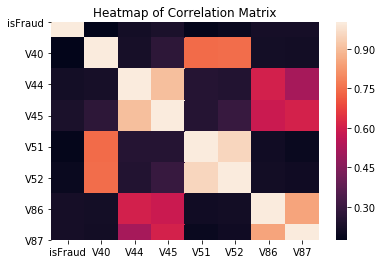

,isFraud,V40,V44,V45,V51,V52,V86,V87
isFraud,1.000000,0.174672,0.217870,0.235436,0.182007,0.195492,0.222343,0.221568
V40,0.174672,1.000000,0.225232,0.271469,0.744831,0.745758,0.217055,0.213533
V44,0.217870,0.225232,1.000000,0.905537,0.257145,0.251881,0.604776,0.515480
V45,0.235436,0.271469,0.905537,1.000000,0.257400,0.296102,0.585396,0.608788
V51,0.182007,0.744831,0.257145,0.257400,1.000000,0.954315,0.212453,0.196567
V52,0.195492,0.745758,0.251881,0.296102,0.954315,1.000000,0.215183,0.207535
V86,0.222343,0.217055,0.604776,0.585396,0.212453,0.215183,1.000000,0.850021
V87,0.221568,0.213533,0.515480,0.608788,0.196567,0.207535,0.850021,1.000000


In [5]:
fraud_summary = df_features.groupby('isFraud')
fraud_summary.mean().to_csv('/Users/krahman/work/fraud_detection/saved_files/fraud_summary.csv')

corr = df_features.corr()
corr.to_csv('/Users/krahman/work/fraud_detection/saved_files/corr_matrix.csv')
corr2 = corr[corr['isFraud']>.17]
corr2 = corr2.loc[:,corr2.index]

sns.heatmap(corr2,
           xticklabels=corr2.columns.values,
           yticklabels=corr2.columns.values)
plt.title('Heatmap of Correlation Matrix')
plt.show()
corr2

In [ ]:
# plt.figure(figsize=(14,4))
# sns.barplot(x='V44', y='V44', hue='isFraud', data=df_train)
# plt.show()

# sns.lmplot(x='addr1', y='addr2', data=df_features,
#            fit_reg=False, hue='isFraud')
# plt.show()

# sns.distplot(df_features.addr1)
# plt.show()

# plt.scatter(X.card1, y)
# sns.regplot(x='card5_237.0', y='isFraud', data=pp.df_train, logistic=True, color='b')

## Splitting features dataframe

In [ ]:
# # create features, target and split the dataframe
# X = pp.df_train.drop(col_target, axis=1)
# X = X.drop(col_id, axis=1)
# y = pp.df_train[col_target]
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.1, random_state=42)

In [ ]:
# X = df_features.drop(col_target, axis=1)
# X = X.drop(col_id, axis=1)
# y = df_features[col_target]
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

### Test Dropping Features On Base Model

In [ ]:
# ###DELETE

# class Results():
#     def __init__(self):
#         self.model_lr_results = pd.DataFrame()
#         self.model_recall = []
#         self.model_precision = []
# #         self.model_auc_score = []
        
#     def _score(self, y_true, y_pred):
#         self.model_recall.append(recall_score(y_true, y_pred))
#         self.model_precision.append(precision_score(y_true, y_pred))
#         self._create_series()
# #         self.model_auc_score.append(roc_auc_score(y_true, y_pred[:,1]))

#     def _create_series(self):
#         model_recall = pd.Series(self.model_recall, name='recall')
#         model_precision = pd.Series(self.model_precision, name='precision')
# #         model_auc_score = pd.Series(self.model_auc_score, name='auc_score')
#         model_results_final = pd.concat([model_recall, model_precision],axis=1)
#         return model_results_final

# df_temp = pd.DataFrame(pca.explained_variance_ratio_)
# df_temp[0:20]
# pd.DataFrame(pca.components_, columns=list(X_temp.columns), index=range(0,225))
# pca.components_

#### Applying PCA (2 components)

In [ ]:
# # standardizing our data, which is required for PCA.
# scaled_X = StandardScaler().fit_transform(X)

# # PCA instantiate and fit 
# pca = PCA(n_components=2)
# pcomponents = pca.fit_transform(scaled_X)
# X_pca = pd.DataFrame(data = pcomponents, columns=['PC1','PC2'])
# print(X_pca.shape)
# X_pca.head()

# # two principal components scatter plot
# plt.figure(figsize=(8,6))
# plt.scatter(X_pca['PC1'], X_pca['PC2'], c=y['isFraud'])
# plt.xlabel('First principal component')
# plt.ylabel('Second principal component')

# # explaining vaariance
# print('Variance ratio:')
# print(pca.explained_variance_ratio_)
# # interpreting principal components
# print('\nPrincipal components explained:')
# pd.DataFrame(pca.components_, columns=list(X.columns), index=('PC1', 'PC2'))

#### Applying PCA to all features (all components)

### EDA

In [ ]:
# sns.lmplot(x='addr1', y='addr2', data=df_features,
#            fit_reg=False, hue='isFraud')
# plt.title('addr1 versus addr2')
# plt.show()

# sns.distplot(df_features.addr1)
# plt.title('Addr1 Distribution')
# plt.show()

In [ ]:
# Hypothesis: less occurring email domains are more likely to have higher fraud_perc because they are 
# perhaps an email provider with less resources. The card that the holder has attached to certain email
# addresses puts them at higher risk for fraud. 

### Feature Engineering Class

In [175]:
class FeatureEngineering():
    '''create new features for columns without ordinal values'''
    def __init__(self):
        self.list_fraud_perc = []
        self.df_feat = df_features.copy()
        self.df_raw = df_raw.copy()
        
        self.len_df_feat = self.df_feat.shape[0]
        self.dict_all_feat = {}
        self.new_col = []
        
        self.col = []
        self.col_fe = []
        self.df_new_feat = pd.DataFrame()
        self.list_drop_col = []
        self.str_list_col_fe = []
        self.list_feat = []

    def feature_testing(self, bool_drop_col, list_feat):
        '''testing and scoring new potential features'''
        print("While running feature_testing, do not run final_features.")            
        if list_feat:
            for col in list_feat:
                self.col_fe = col
                bool_predict_proba = False
                if col in df_features.columns:
                    df_feat = self.create_test_feature(bool_drop_col, col)
                    if df_feat_1000:
                        df_feat = df_feat[0:1000] ### delete
                    df_feat = df_feat.drop(self.list_drop_col[-1], axis=1)
                    self._apply_df_transform(df_feat)
                    model_lr = LogisticRegression(random_state=42, n_jobs=-1)
                    self._convert_list_to_string(list_feat)
                    mod.create_df_score_model(model_lr)
                else:
                    print("\nColumn", col, "does not exist in dataframe.\n")
            self.col_fe = []
        self.list_drop_col = []
            
    def final_features(self, bool_drop_col, list_feat):
        '''creates final new features'''
        print('After running final_features, run create_final_df.')
        self.list_feat = list_feat
        df_feat = self.create_feature(bool_drop_col, list_feat)  
        if df_feat_1000:
            df_feat = df_feat[0:1000] ### delete
        for col in list_feat:
            col_fe = self._append_col_lists(col)
            df_feat[col] = self._fill_na(df_feat, col_fe)
            self._concat_df_new_feat(df_feat, col_fe)
        self._convert_list_to_string(list_feat)
        return df_feat ### delete?
    
    def _append_col_lists(self, col):
        '''appending columns and new feature column names'''
        col_fe = col + '_fe'
        self.col.append(col)
        self.col_fe.append(col_fe)
        return col_fe
    
    def _fill_na(self, df_feat, col_fe):
        '''fill na values for new features'''
        col_mode = df_feat[col_fe].mode()[0]
        return df_feat[col_fe].fillna(col_mode)
        
    def _concat_df_new_feat(self, df_feat, col_fe):
        '''adding new feauture columns to one dataframe'''  
        df_temp = df_feat[col_fe]
        self.df_new_feat = pd.concat([self.df_new_feat, df_temp], axis=1)
    
    def _convert_list_to_string(self, list_feat):
        '''convert list to string to print later'''
        str_temp = ''
        for val in list_feat:
            str_temp = str_temp + val + ' '
        self.str_list_col_fe = str_temp

    def create_final_df(self):
        '''creates final dataframe after creating final_features'''
        df_feat = pd.concat([df_features, self.df_new_feat], axis=1) # comment out when 0:1000
        if df_feat_1000:
            df_feat = pd.concat([df_features[0:1000], self.df_new_feat], axis=1) ### delete
        print('Dropping columns: ', self.list_drop_col)
        df_feat = df_feat.drop(self.list_drop_col, axis=1)
        self._apply_df_transform(df_feat)
        self._create_tuning_df(df_feat)
        self.list_drop_col = [] ### testing
        print("final dataframe created.")
        
    def _apply_df_transform(self, df_feat):
        '''create dataframe, apply pca, apply smote'''
        self.df_feat = df_feat
        X, y = self._drop_col_id_target(df_feat)
        self._apply_pca(X, y)
        self._apply_smote()

    def _create_tuning_df(self, df_feat):
        '''whole dataframe used for model tuning'''
        if bool_create_tuning_df:
            X, y = self._drop_col_id_target(df_feat)
            X = self._pca(X)
            sm = SMOTE(random_state=42, n_jobs=-1)
            mod.X_features, mod.y_target = sm.fit_sample(X, y)
            print('tuning dataframe created.')
        else:
            print('bool_create_tuning_df set to false.')

    def _drop_col_id_target(self, df_feat):
        '''dropping col id and target from features and creating target dataframe'''
        X = df_feat.drop(col_target, axis=1)
        X = X.drop(col_id, axis=1)
        y = df_feat[col_target]
        return X, y
    
    def _apply_pca(self, X, y):
        '''applying PCA and creating train and test set'''
        if bool_apply_pca:
            X_pca = self._pca(X)
            self._split_dataframe(X_pca, y)
            print('PCA applied.')
        else:
            print("bool_apply_pca set to false.")
            self._split_dataframe(X, y)
            
    def _pca(self, X):
        '''applying pca features dataframe'''
        scaled_X = StandardScaler().fit_transform(X)
        pca = PCA(n_components=250) #set value
        pcomponents = pca.fit_transform(scaled_X)
        X_pca = pd.DataFrame(data=pcomponents)
        return X_pca

    def _split_dataframe(self, X, y):
        '''splitting dataframe into training and test set'''
        mod.X_train, mod.X_test, mod.y_train, mod.y_test = train_test_split(X, 
                                                                            y, 
                                                                            test_size=0.1, 
                                                                            random_state=42)

    def _apply_smote(self):
        '''applying smote to split training set'''
        if bool_apply_smote:
            sm = SMOTE(random_state=42, n_jobs=-1)
            mod.X_train, mod.y_train = sm.fit_sample(mod.X_train, 
                                                     mod.y_train)
            print("smote applied.")
        else:
            print("bool_apply_smote set to false.")
        
    def create_test_feature(self, bool_drop_col, col):
        '''creates correllated ratio to target column'''
        df_feat = df_features.copy()        
        df_feat = self._calculate_target_perc(col, df_feat) 
        df_feat = self._map_col(col, df_feat)
        df_feat = self._create_ratio(df_feat)
        df_feat = self._drop_column(bool_drop_col, col, df_feat)
        return df_feat
    
    def create_feature(self, bool_drop_col, list_col):
        '''creating new feature'''
        df_feat = self.df_feat       
        for col in list_col:
            df_feat = self._check_col_exist(col, df_feat)
            df_feat = self._calculate_target_perc(col, df_feat) 
            df_feat = self._map_col(col, df_feat)
            df_feat = self._create_ratio(df_feat)
            df_feat = self._drop_column(bool_drop_col, col, df_feat)
        return df_feat 
    
    def _check_col_exist(self, col, df_feat):
        '''recreates original column from original dataframe'''
        if col not in df_feat.columns:
            df_feat[col] = df_raw[col]
            df_feat[col] = self._fill_na(df_feat, col)
            df_feat[col] = self._label_encode(df_feat, col)
        return df_feat
    
    def _label_encode(self, df_feat, col):
        '''label encoding columns pulled from original df_raw'''
        le = LabelEncoder()
        df_feat[col] = le.fit_transform(df_feat[col])
        return df_feat[col]
    
    def _drop_column(self, bool_drop_col, col, df_feat):
        '''dropping or keeping columns'''
        if bool_drop_col:
            if (col in df_features.columns):    
                self.list_drop_col.append(col) 
        else:
            print("Keeping original feature", col)
        return df_feat

    def aggregate_features(self, list_col, val_aggreg):
        for col in list_col:
            df_groupby = self.df_raw.groupby(col).mean()
            dict_aggreg_col = df_groupby[[val_aggreg]].to_dict()
            self.df_feat[col + '_fe'] = self.df_raw[col].map(dict_aggreg_col['TransactionAmt'])
            col_mode = self.df_feat[col + '_fe'].mode()[0]
            self.df_feat[col + '_fe'] = self.df_feat[col + '_fe'].fillna(col_mode)

    def _calculate_target_perc(self, col_val, df_feat):
        '''calculate fraud percentage for each column'''
        list_perc = []
        dict_feat = {}
        unique_col_values = df_feat[col_val].unique()
        for val in unique_col_values:
            list_perc = self._append_fraud_percentage(df_feat, col_val, val, list_perc)    
        self._create_dict(col_val, list_perc, unique_col_values) # call _create_dict 
        return df_feat
    
    def _append_fraud_percentage(self, df_feat, col_val, val, list_perc):
        '''calculating fraud percentage and adding to list'''
        fraud_total = df_feat[(df_feat[col_val]==val) 
                            & (df_feat[col_target]==1)].shape[0]
        non_fraud_total = df_feat[(df_feat[col_val]==val) 
                                & (df_feat[col_target]==0)].shape[0]
        if (non_fraud_total==0):
            list_perc.append(0)
        else: 
            list_perc.append(fraud_total/non_fraud_total)
        return list_perc

    def _create_dict(self, col_val, list_perc, unique_col_values):
        '''create dictionary for original values to new fraud percent values'''
        col_name = col_val + '_fraud_perc'
        series_perc = pd.Series(list_perc, name=col_name)
        series_col = pd.Series(unique_col_values, name=col_val)
        df_feat = pd.concat([series_col, series_perc], axis=1)
        df_feat = df_feat.sort_values(col_name, ascending=False) 
        dict_feat = df_feat.set_index(col_val).to_dict()
        self.dict_all_feat.update(dict_feat)

    def _map_col(self, col, df_feat):
        '''map dictionary values to new features'''
        dict_keys = self.dict_all_feat.keys()
        for val in dict_keys:
            df_feat[col + '_fe'] = df_feat[col].map(self.dict_all_feat[val])
            self.new_col.append(col + '_fe')
        return df_feat
            
    def _create_ratio(self, df_feat):
        '''finalize new features with ranking values'''
        for val in self.new_col:
            col_min_val = df_feat[df_feat[val] > 0][val].min()
            df_feat[val] = df_feat[val]/col_min_val
        self.new_col = []
        return df_feat

fe = FeatureEngineering()

bool_apply_pca = False
bool_apply_smote = True
df_feat_1000 = False
bool_create_tuning_df = True
bool_drop_col = True
fe.final_features(bool_drop_col, list_feat=['addr1','addr2','card2','card3','C1','P_emaildomain', 
                                            'card6', 'V294','V279','C14','V306','D2','D10'])
bool_drop_col = False
fe.final_features(bool_drop_col, list_feat=['card5', 'V317', 'V69', 'D1','D3','D4','D11'])
fe.list_drop_col.append('C4')

fe.create_final_df()

# fe.feature_testing(bool_drop_col, list_feat=['addr1'])

# NEXT, fix bugs in fe, then check to see that mod.X_features works, then check mod.y_target. check
# model scores right, then clean up code, then test the new def we created. then go back to 
# model tuning 

After running final_features, run create_final_df.
After running final_features, run create_final_df.
Keeping original feature card5
Keeping original feature V317
Keeping original feature V69
Keeping original feature D1
Keeping original feature D3
Keeping original feature D4
Keeping original feature D11
Dropping columns:  ['addr1', 'addr2', 'card2', 'card3', 'C1', 'V294', 'V279', 'C14', 'V306', 'D2', 'D10', 'C4']
bool_apply_pca set to false.
smote applied.
tuning dataframe created.
final dataframe created.


In [176]:
bool_predict_proba = False
model_current = LogisticRegression(random_state=42)
mod.create_df_score_model(model_current)

Fitting model:
 LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=42, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)
roc score: 0.7163359236144149

The following new features have been created: ['addr1_fe', 'addr2_fe', 'card2_fe', 'card3_fe', 'C1_fe', 'P_emaildomain_fe', 'card6_fe', 'V294_fe', 'V279_fe', 'C14_fe', 'V306_fe', 'D2_fe', 'D10_fe', 'card5_fe', 'V317_fe', 'V69_fe', 'D1_fe', 'D3_fe', 'D4_fe', 'D11_fe'] 

              precision    recall  f1-score   support

           0       0.99      0.68      0.81     56945
           1       0.08      0.75      0.15      2109

    accuracy                           0.69     59054
   macro avg       0.53      0.72      0.48     59054
weighted avg       0.95      0.69      0.78     59054


Printing df_scores...

      fea

In [177]:
len(mod.X_features)

1139754

In [178]:
len(mod.y_target)

1139754

In [162]:
# model_current = DecisionTreeClassifier(random_state=42)
# mod.create_df_score_model(model_current)

,0,1,2,3,4,5,6,7,8,9,...,240,241,242,243,244,245,246,247,248,249
0,-1.679144,-0.349748,2.802287,-0.910563,-1.207496,-0.823423,0.064612,-0.973015,-0.169964,0.439863,...,-0.039477,0.027419,-0.022020,-0.034622,-0.013778,-0.047151,0.032487,0.001580,-0.015699,0.009081
1,-0.484195,-0.519751,1.520535,-1.255726,-1.446283,-0.625314,0.096616,1.226491,0.411590,0.507778,...,-0.001498,-0.006161,0.011493,-0.001804,-0.018336,-0.002907,0.001749,-0.005224,0.002790,0.005139
2,-1.971773,-0.558737,2.231490,-0.829415,-0.788181,-0.562928,-0.153909,0.528396,-0.599256,-0.231679,...,0.006192,-0.002288,-0.005354,0.030081,0.007492,-0.002601,-0.052287,-0.013559,0.010516,-0.008645
3,-2.269332,2.874889,1.927759,0.254433,0.975446,0.468235,3.082074,2.616242,-0.787795,-0.057923,...,-0.109701,0.320159,0.045039,0.060854,-0.004809,-0.069659,-0.055047,0.008236,0.008185,0.002729
4,-0.720992,-0.154942,4.493407,-1.478024,-1.433028,-1.421843,-1.694828,-0.255056,1.079694,1.349497,...,-0.004530,-0.007863,-0.002951,-0.010845,-0.007048,-0.000085,-0.002750,0.005891,-0.005743,-0.002140
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590535,-4.212123,0.011435,-1.266686,-0.482762,-0.334057,0.086208,1.267565,-6.218330,-1.117837,-0.936203,...,0.031624,0.018982,0.021076,-0.006782,0.056734,-0.008682,-0.017213,-0.015694,-0.037610,-0.030081
590536,-2.278867,-0.404907,2.593187,-0.680588,-0.567999,-0.305401,-0.665731,0.349376,-0.810003,-1.252163,...,-0.002034,0.002215,-0.001707,0.002329,0.009871,0.005409,0.014123,-0.004080,-0.004296,0.004941
590537,-3.486385,-0.516122,-2.024323,0.196702,0.906089,0.639536,-3.415815,-1.415500,0.808632,-0.973828,...,-0.002390,0.000487,-0.007667,0.008861,-0.016099,0.004767,0.014420,0.016204,0.011329,-0.010130
590538,-0.464533,0.828484,5.268476,2.831623,6.269637,3.023542,-0.821574,4.769562,1.859054,-0.735273,...,0.094414,0.149153,0.029822,0.316190,-0.078859,0.096156,-0.124994,-0.003841,-0.300051,-0.321546


Fitting model:
 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators='warn',
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)
roc score: 0.7653269954567143
              precision    recall  f1-score   support

           0       0.98      0.98      0.98     56945
           1       0.57      0.55      0.56      2109

    accuracy                           0.97     59054
   macro avg       0.78      0.77      0.77     59054
weighted avg       0.97      0.97      0.97     59054


Printing df_scores...

      feat_tested     fn       fp  precision    recall  time_elapsed (min)  \
332     addr1_fe  682.0  19343.0   

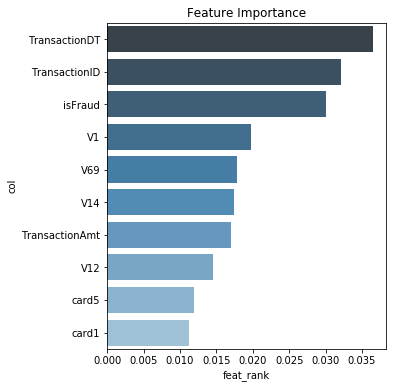

              col  feat_rank
0   TransactionDT   0.036505
1   TransactionID   0.032122
2         isFraud   0.030023
3              V1   0.019718
4             V69   0.017775
5             V14   0.017476
6  TransactionAmt   0.016972
7             V12   0.014583
8           card5   0.011881
9           card1   0.011186


In [134]:
bool_predict_proba = False
model_current = RandomForestClassifier(random_state=42, n_jobs=-1)
mod.create_df_score_model(model_current)

In [40]:
# bool_predict_proba = False
# model_current = LogisticRegression(random_state=42)
# mod.create_df_score_model(model_current) 


In [153]:
class Model():
    def __init__(self, bool_smote):
        self.X_train = pd.DataFrame()
        self.y_train = pd.DataFrame()
        self.X_test = pd.DataFrame()
        self.y_test = pd.DataFrame()
        self.X_features = pd.DataFrame()
        self.y_target = pd.DataFrame()
        
    def create_df_score_model(self, model_current):
        '''scores model'''
        print("Fitting model:\n", model_current)
        y_pred, elapsed_time = self.add_model(model_current) 
        df_scores, df_temp, y_pred = self._score_model(y_pred, 
                                                       elapsed_time)
        self._save_results(df_scores, df_temp, y_pred)
        self._feature_importance(model_current)
        fe.col_fe = []
        
    def add_model(self, model):        
        '''fitting model and calculating time elapsed'''
        start_time = time.time()
        model.fit(mod.X_train, mod.y_train)
        y_pred = self._predict(model)
        elapsed_time = (time.time() - start_time) / 60
        return y_pred, elapsed_time
    
    def _predict(self, model):
        '''make prediction'''
        if bool_predict_proba:
            y_pred = self._predict_proba(model)
            return y_pred 
        else:
            y_pred = model.predict(mod.X_test)
            return y_pred
        
    def _predict_proba(self, model):
        try:
            y_pred_prob = model.predict_proba(mod.X_test)
            y_pred_class = self._predict_proba_threshold(y_pred_prob)
            return y_pred_class
        except:
            print("Model does not have predict_proba attribute.")
            
    def _predict_proba_threshold(self, y_pred_prob):
        for threshold in [.1, .15, .2, .25, .3, .35, .4, .45, .5]:
            print('threshold: ', threshold)
            y_pred_class = binarize(y_pred_prob, threshold)[:,1]
            print('roc auc score:', roc_auc_score(mod.y_test, y_pred_class))
            print('confusion matrix:\n', confusion_matrix(mod.y_test, y_pred_class))
        return y_pred_class
            
#     def _create_roc_curve(self, y_pred_class):
#         fpr, tpr, thresholds = roc_curve(mod.y_test, y_pred_class)
#         plt.plot(fpr, tpr)
#         plt.xlim([0.0, 1.0])
#         plt.ylim([0.0, 1.0])
#         plt.title("ROC curve for classifier")
#         plt.xlabel("False Positive Rate (1 - Specificity)")
#         plt.ylabel("True Positive Rate (Sensitivity)")
#         plt.grid(True)
#         plt.show()
        
    def _score_model(self, y_pred, elapsed_time):      
        '''creating dataframe with score results'''
        col_recall, col_precision, col_time = self._calc_scores(y_pred, 
                                                                  elapsed_time)        
        df_conf_matrix = self._confusion_matrix(y_pred)
        df_temp = pd.concat([col_recall, col_precision, df_conf_matrix, col_time], axis=1)
        if fe.col_fe:
            df_temp = self._concat_new_feat(df_temp)
        df_scores = self._read_create_score_file(df_temp)
        return df_scores, df_temp, y_pred

    def _calc_scores(self, y_pred, elapsed_time):
        '''calculating recall, precision and elapsed time'''
        col_recall = pd.Series(recall_score(mod.y_test, y_pred), name='recall')
        col_precision = pd.Series(precision_score(mod.y_test, y_pred), name='precision')
        col_time = pd.Series(elapsed_time, name='time_elapsed (min)')
        print("roc score:", roc_auc_score(mod.y_test, y_pred))
        return col_recall, col_precision, col_time
    
    def _confusion_matrix(self, y_pred):
        '''creating confusion matrix dataframe'''
        df_conf_matrix = pd.DataFrame(confusion_matrix(mod.y_test, y_pred))
        val_tp = pd.Series(df_conf_matrix[0][0], name='tp')
        val_fn = pd.Series(df_conf_matrix[0][1], name='fn')
        val_fp = pd.Series(df_conf_matrix[1][0], name='fp')
        val_tn = pd.Series(df_conf_matrix[1][1], name='tn')
        return pd.concat([val_fn, val_fp, val_tp, val_tn], axis=1)

    def _concat_new_feat(self, df_temp):
        '''concatenate scoring results'''        
        print("\nThe following new features have been created:", fe.col_fe, '\n')
        if len(fe.col_fe) > 1: 
            fe.col_fe = "model score"
        col_fe = pd.Series(fe.col_fe, name='feat_tested')
        return pd.concat([col_fe, df_temp], axis=1)
    
    def _read_create_score_file(self, df_temp):
        '''reading or creating df_scores file'''
        try: 
            df_scores = pd.read_csv('/Users/krahman/work/fraud_detection/saved_files/df_scores.csv')
            df_scores = df_scores.drop('Unnamed: 0', axis=1)
        except:
            print("\nCreating df_scores.csv file.") 
            df_scores = df_temp
        return df_scores
            
    def _save_results(self, df_scores, df_temp, y_pred):
        '''printing scores for new features'''            
        df_scores = pd.concat([df_scores, df_temp], axis=0)
        df_scores.to_csv('/Users/krahman/work/fraud_detection/saved_files/df_scores.csv')
        classif_report = classification_report(mod.y_test, y_pred)
        self._print_summary(classif_report, df_scores)
        self._save_summary(classif_report)

    def _print_summary(self, classif_report, df_scores):
        '''print last 5 rows of previous score results'''
        print(classif_report)
        print('\nPrinting df_scores...\n\n', df_scores.tail(5))
    
    def _save_summary(self, classif_report):
        '''save score result summary to text file'''
        file_summary = open('/Users/krahman/work/fraud_detection/saved_files/df_scores_summary.txt', "a")
        file_summary.write('New features created from: ' 
                           + fe.str_list_col_fe 
                           + '\n')
        file_summary.write(classif_report)
        file_summary.close()
        
    def _feature_importance(self, model):
        '''create feature importance dataframe and bar plot'''
        try:
            df_feat_rank = self._feat_import_create_df(model)
            self._feat_import_create_plot(df_feat_rank)
            print(df_feat_rank[0:10].reset_index(drop=True))
        except:
            print("\nmodel does not have _feature_importance attribute.")
        
    def _feat_import_create_df(self, model):
        '''creating dataframe of important features'''
        col_name = pd.Series(fe.df_feat.columns, name='col')
        col_feat_rank = pd.Series(model.feature_importances_, 
                                  name='feat_rank')
        df_feat_rank = pd.concat([col_name, col_feat_rank], axis=1)
        df_feat_rank = df_feat_rank.sort_values('feat_rank', ascending=False)
        return df_feat_rank
    
    def _feat_import_create_plot(self, df_feat_rank):
        '''create feature importance bar plot'''
        plt.figure(figsize=(5,6))
        sns.barplot(df_feat_rank.feat_rank[0:10],
                    df_feat_rank.col[0:10],
                    palette='Blues_d')
        plt.title('Feature Importance')
        plt.show()
        
mod = Model(bool_smote=True)      

# then Consider creating fe from TransactionAmt
# NEXT, do more EDA

In [122]:
model_xgbc = XGBClassifier()
model_xgbc.fit(mod.X_train, mod.y_train)
y_pred_xgbc = model_xgbc.predict(mod.X_test)
print(classification_report(mod.y_test, y_pred_xgbc))
print(confusion_matrix(mod.y_test, y_pred_xgbc))

In [ ]:
model_cbc = CatBoostClassifier()
model_cbc.fit(mod.X_train, mod.y_train)
y_pred_cbc = model_cbc.predict(mod.y_test)
print(classification_report(mod.y_test, y_pred_cbc))
print(confusion_matrix(mod.y_test, y_pred_cbc))


## Model Tuning

### RFC Tuning

In [ ]:
# NEXT, before we keep tuning, we need to score on whole dataframe, so fix and test our method...
# then we. need to add roc_score to tuning method... or once we get rfc results we can test to see if
# it makes a difference or see if there is some kind of built in method we can use. 

# NEXT, we need to set up tuning for LogisticRegression, then XGBoostClassifier


In [183]:
#### Tuning RandomForestClassifier ####
rfc = RandomForestClassifier(oob_score=False, n_jobs=-1, random_state=42, verbose=1)

n_estimators = [50,75,100,125,150,200]
criterion = ['gini', 'entropy']
max_depth = [3,5,7,9,11,13,15, None]
min_samples_split = [2,3,5,7,9]
min_samples_leaf = [1,2,4,6,8,10]
min_weight_fraction_leaf = [0,.1,.2,.3,.4,.5]
max_features = ['auto', 'sqrt', 'log2', None]
max_leaf_nodes = [2,3,5,7,9,None]
min_impurity_decrease = [0,.1,.3,.5,.7,.9]

# n_estimators = [50,75,100,125]
# criterion = ['gini']
# max_depth = [2,3,4,5,6,7,None]
# min_samples_split = [6,7,8,9]
# min_samples_leaf = [1,2]
# min_weight_fraction_leaf = [0]
# max_features = ['auto', 'sqrt', 'log2', None]
# max_leaf_nodes = [None]
# min_impurity_decrease = [0]

hyperparameters = dict(n_estimators=n_estimators, criterion=criterion, max_depth=max_depth, 
                       min_samples_split=min_samples_split,
                       min_samples_leaf=min_samples_leaf, min_weight_fraction_leaf=min_weight_fraction_leaf,
                       max_features=max_features, max_leaf_nodes=max_leaf_nodes,
                       min_impurity_decrease=min_impurity_decrease
                      )

clf = RandomizedSearchCV(rfc, hyperparameters, random_state=42, cv=5, verbose=5, n_jobs=-1, scoring='roc_auc')
best_model = clf.fit(mod.X_features, mod.y_target)

# best hyper parameters
print('Best n_estimators:', best_model.best_estimator_.get_params()['n_estimators'])
print('Best criterion:', best_model.best_estimator_.get_params()['criterion'])
print('Best max_depth:', best_model.best_estimator_.get_params()['max_depth'])
print('Best min_samples_split:', best_model.best_estimator_.get_params()['min_samples_split'])
print('Best min_samples_leaf:', best_model.best_estimator_.get_params()['min_samples_leaf'])
print('Best min_weight_fraction_leaf:', best_model.best_estimator_.get_params()['min_weight_fraction_leaf'])
print('Best max_features:', best_model.best_estimator_.get_params()['max_features'])
print('Best max_leaf_nodes:', best_model.best_estimator_.get_params()['max_leaf_nodes'])
print('Best min_impurity_decrease:', best_model.best_estimator_.get_params()['min_impurity_decrease'])


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


KeyboardInterrupt: 

In [159]:
#### LR Tuning ####
lr = LogisticRegression(n_jobs=-1, random_state=42, verbose=1)

penalty = ['l1', 'l2', 'elasticnet', 'none']
tol = [1e-1,1e-2,1e-3,1e-4,1e-5,1e-6,1e-7]
C = [1e-1,.2,.3,.5,.7,1]
fit_intercept = [True,False]
intercept_scaling = [1,.1,.01,.001]
class_weight = ['balanced', None]
solver = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
max_iter = [50,75,100,150,200]
multi_class = ['auto', 'ovr', 'multinomial']
l1_ratio = [1e-1,1e-2,1e-3,1e-4,1e-5,1e-6,1e-7]


hyperparameters = dict(penalty=penalty, tol=tol, C=C, 
                       fit_intercept=fit_intercept,
                       intercept_scaling=intercept_scaling, class_weight=class_weight,
                       solver=solver, max_iter=max_iter,
                       multi_class=multi_class, l1_ratio=l1_ratio
                      )

clf = RandomizedSearchCV(lr, hyperparameters, random_state=42, cv=5, verbose=1, n_jobs=-1, scoring='roc_auc')
best_model = clf.fit(mod.X_features, mod.y_target)

# best hyper parameters
print('Best penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Best tol:', best_model.best_estimator_.get_params()['tol'])
print('Best C:', best_model.best_estimator_.get_params()['C'])
print('Best fit_intercept:', best_model.best_estimator_.get_params()['fit_intercept'])
print('Best intercept_scaling:', best_model.best_estimator_.get_params()['intercept_scaling'])
print('Best class_weight:', best_model.best_estimator_.get_params()['class_weight'])
print('Best solver:', best_model.best_estimator_.get_params()['solver'])
print('Best max_iter:', best_model.best_estimator_.get_params()['max_iter'])
print('Best multi_class:', best_model.best_estimator_.get_params()['multi_class'])
print('Best l1_ratio:', best_model.best_estimator_.get_params()['l1_ratio'])


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


KeyboardInterrupt: 

In [193]:
#### Tuning DTC ####
dt = DecisionTreeClassifier(random_state=42)

criterion = ['gini', 'entropy']
splitter = ['best', 'random']
max_depth = [3,5,7,9,11, None]
min_samples_split = [2,3,5,7,9]
min_samples_leaf = [1,3,5,7,9]
min_weight_fraction_leaf = [0,.1,.2,.3,.4,.5]
max_features = ['auto', 'sqrt', 'log2', None]
class_weight = ['balanced', None]

hyperparameters = dict(criterion=criterion, splitter=splitter, max_depth=max_depth, 
                       min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, 
                       min_weight_fraction_leaf=min_weight_fraction_leaf,
                       max_features=max_features, class_weight=class_weight
                      )

clf = RandomizedSearchCV(dt, hyperparameters, random_state=42, cv=5, verbose=1, n_jobs=-1, scoring='roc_auc')
best_model = clf.fit(mod.X_features, mod.y_target)

# best hyper parameters
print('Best criterion:', best_model.best_estimator_.get_params()['criterion'])
print('Best splitter:', best_model.best_estimator_.get_params()['splitter'])
print('Best max_depth:', best_model.best_estimator_.get_params()['max_depth'])
print('Best min_samples_split:', best_model.best_estimator_.get_params()['min_samples_split'])
print('Best min_samples_leaf:', best_model.best_estimator_.get_params()['min_samples_leaf'])
print('Best min_weight_fraction_leaf:', best_model.best_estimator_.get_params()['min_weight_fraction_leaf'])
print('Best max_features:', best_model.best_estimator_.get_params()['max_features'])
print('Best class_weight:', best_model.best_estimator_.get_params()['class_weight'])


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


KeyboardInterrupt: 

In [ ]:
# #### Tuning DecisionTreeClassifier #### 
# dt = DecisionTreeClassifier(random_state=42)

# criterion = ['gini', 'entropy']
# splitter = ['best', 'random']
# max_depth = [3,5,7,9,11, None]
# min_samples_split = [2,3,5,7,9]
# min_samples_leaf = [1,3,5,7,9]
# min_weight_fraction_leaf = [0,.1,.2,.3,.4,.5]
# max_features = ['auto', 'sqrt', 'log2', None]
# class_weight = ['balanced', None]

# hyperparameters = dict(criterion=criterion, splitter=splitter, max_depth=max_depth, 
#                        min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, 
#                        min_weight_fraction_leaf=min_weight_fraction_leaf,
#                        max_features=max_features, class_weight=class_weight
#                       )

# clf = RandomizedSearchCV(dt, hyperparameters, random_state=42, cv=5, verbose=1, n_jobs=-1, scoring='roc_auc')
# best_model = clf.fit(mod.X_features, mod.y_target)

# # best hyper parameters
# print('Best criterion:', best_model.best_estimator_.get_params()['criterion'])
# print('Best splitter:', best_model.best_estimator_.get_params()['splitter'])
# print('Best max_depth:', best_model.best_estimator_.get_params()['max_depth'])
# print('Best min_samples_split:', best_model.best_estimator_.get_params()['min_samples_split'])
# print('Best min_samples_leaf:', best_model.best_estimator_.get_params()['min_samples_leaf'])
# print('Best min_weight_fraction_leaf:', best_model.best_estimator_.get_params()['min_weight_fraction_leaf'])
# print('Best max_features:', best_model.best_estimator_.get_params()['max_features'])
# print('Best class_weight:', best_model.best_estimator_.get_params()['class_weight'])


In [196]:
### Tuning XGBClassifier ###

xgbc = XGBClassifier(n_jobs=-1, random_state=42)

max_depth = [2,3,5,7,9,11,13]
learning_rate = [0,.1,.3,.5,.7,.9]
booster = ['gbtree', 'gblinear', 'dart']
subsample = [1,3,5,7]
colsample_bytree = [1,3,5,7]
colsample_bylevel = [1,3,5,7]
colsample_bynode = [1,3,5,7]
reg_alpha = [0,1,3,5,7]
reg_lambda = [1,3,5,7]
scale_pos_weight = [1,3,5,7]
base_score = [.1,.2,.3,.4,.5]

hyperparameters = dict(max_depth=max_depth, learning_rate=learning_rate, booster=booster, 
                       subsample=subsample, colsample_bytree=colsample_bytree, 
                       colsample_bylevel=colsample_bylevel, colsample_bynode=colsample_bynode,
                       reg_alpha=reg_alpha, reg_lambda=reg_lambda, scale_pos_weight=scale_pos_weight,
                       base_score=base_score
                      )

clf = RandomizedSearchCV(xgbc, hyperparameters, random_state=42, cv=5, verbose=1, n_jobs=-1, scoring='roc_auc')
best_model = clf.fit(mod.X_features, mod.y_target)

# best hyper parameters
print('Best max_depth:', best_model.best_estimator_.get_params()['max_depth'])
print('Best learning_rate:', best_model.best_estimator_.get_params()['learning_rate'])
print('Best booster:', best_model.best_estimator_.get_params()['booster'])
print('Best subsample:', best_model.best_estimator_.get_params()['subsample'])
print('Best colsample_bytree:', best_model.best_estimator_.get_params()['colsample_bytree'])
print('Best colsample_bylevel:', best_model.best_estimator_.get_params()['colsample_bylevel'])
print('Best colsample_bynode:', best_model.best_estimator_.get_params()['colsample_bynode'])
print('Best reg_alpha:', best_model.best_estimator_.get_params()['reg_alpha'])
print('Best reg_lambda:', best_model.best_estimator_.get_params()['reg_lambda'])
print('Best scale_pos_weight:', best_model.best_estimator_.get_params()['scale_pos_weight'])
print('Best base_score:', best_model.best_estimator_.get_params()['base_score'])



Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


KeyboardInterrupt: 

In [198]:
### Tuning XGBClassifier ###

cbc = CatBoostClassifier(random_state=42)

max_depth = [2,3,5,7,9,11,13]
learning_rate = [0,.1,.3,.5,.7,.9]
bagging_temperature = []
subsample = [1,3,5,7]
n_estimators = [50,75,100,150]

hyperparameters = dict(max_depth=max_depth, learning_rate=learning_rate, n_estimators=n_estimators, 
                       subsample=subsample
                      )

clf = RandomizedSearchCV(cbc, hyperparameters, random_state=42, cv=5, verbose=1, n_jobs=-1, scoring='roc_auc')
best_model = clf.fit(mod.X_features, mod.y_target)

# best hyper parameters
print('Best max_depth:', best_model.best_estimator_.get_params()['max_depth'])
print('Best learning_rate:', best_model.best_estimator_.get_params()['learning_rate'])
print('Best n_estimators:', best_model.best_estimator_.get_params()['n_estimators'])
print('Best subsample:', best_model.best_estimator_.get_params()['subsample'])


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


KeyboardInterrupt: 

Fitting model:
 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
                       oob_score=False, random_state=42, verbose=0,
                       warm_start=False)
roc score: 0.7653269954567143
              precision    recall  f1-score   support

           0       0.98      0.98      0.98     56945
           1       0.57      0.55      0.56      2109

    accuracy                           0.97     59054
   macro avg       0.78      0.77      0.77     59054
weighted avg       0.97      0.97      0.97     59054


Printing df_scores...

      feat_tested     fn       fp  precision    recall  time_elapsed (min)  \
333     addr1_fe  682.0  19343.0   0.06

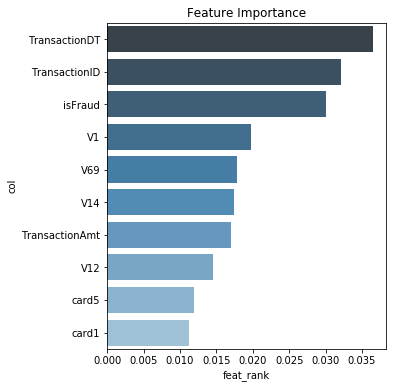

              col  feat_rank
0   TransactionDT   0.036505
1   TransactionID   0.032122
2         isFraud   0.030023
3              V1   0.019718
4             V69   0.017775
5             V14   0.017476
6  TransactionAmt   0.016972
7             V12   0.014583
8           card5   0.011881
9           card1   0.011186
Fitting model:
 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
                       oob_score=False, random_state=42, verbose=0,
                       warm_start=False)
roc score: 0.7653269954567143
              precision    recall  f1-score   support

           0       0.98      0.98      0.98     56945
           1       0.57      0.55      0

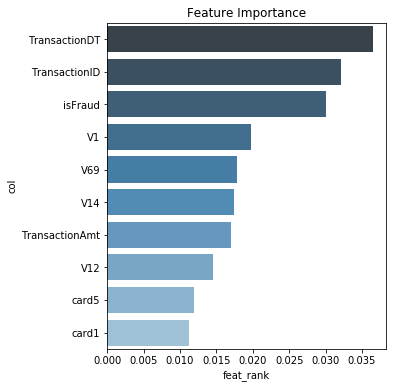

              col  feat_rank
0   TransactionDT   0.036505
1   TransactionID   0.032122
2         isFraud   0.030023
3              V1   0.019718
4             V69   0.017775
5             V14   0.017476
6  TransactionAmt   0.016972
7             V12   0.014583
8           card5   0.011881
9           card1   0.011186


In [143]:
bool_predict_proba = False
# tuned model
current_model = RandomForestClassifier(
                       max_depth=3, max_features='log2',
                       min_impurity_decrease=0.0, 
                       min_samples_leaf=1, min_samples_split=7,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=-1, oob_score=False, random_state=42,
                       verbose=0, warm_start=False)
mod.create_df_score_model(model_current)

# base model
current_model = RandomForestClassifier(random_state=42, n_jobs=-1)
mod.create_df_score_model(model_current)

In [ ]:
# model.create_df_score_model(df_feat)
# 369.0 all col
# 398.0 remove P_emaildomain
# 410.0 remove card6
# 395.0 drop C4
# 415.0 add all back in
# 368.0 test again with C14


In [ ]:
# create feature from TransactionAmt. Add more EDA information. 

In [ ]:
# 1. Model Tuning
# 2. Finished - Features
# 3. more EDA
# 4. Finished - move pca and smote into fe. 

In [ ]:
df_temp_read = pd.read_csv('/Users/krahman/work/fraud_detection/saved_files/df_scores.csv')
df_temp_read[len(df_temp_read)-40:]

In [ ]:
# # it reads the csv, creates a dataframe, then appends the results, then saves over the old version and keeps
# # a record of all columns in the tested dataframe.

# X = df_features.drop(col_target, axis=1)
# X = X.drop(col_id, axis=1)
# y = df_features[col_target]

# # we want to test a feature for feature engineering... we must 

# for col_original, col_new in zip(list_col, fe.list_new_feat):
#     print(col_original, col_new)
#     X[col_new] = fe.df_feat[col_new]
#     X = X.drop(col_original, axis=1)

#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
#     start_time = time.time()

#     sm = SMOTE(random_state=42, ratio=1.0, n_jobs=-1) # SMOTE
#     X_train_res, y_train_res = sm.fit_sample(X_train, y_train)
    
#     model_lr_pca_sm = LogisticRegression(random_state=42, n_jobs=-1) # logistic regression
#     model_lr_pca_sm.fit(X_train_res, y_train_res)
    
#     y_pred = model_lr_pca_sm.predict(X_test)     # predict
    
#     elapsed_time = time.time() - start_time
#     print('\nTime elapsed:', elapsed_time / 60)
#     print(confusion_matrix(y_test, y_pred))
#     print(classification_report(y_test, y_pred))
    
# #     X = X.drop(col, axis=1)
#     print(list(X.columns))

In [ ]:
# fe.df_feat['time_delta'] = df_temp['time_delta']
# fe.df_feat['time_delta_week'] = df_temp['time_delta']/7
# fe.df_feat['time_delta_month'] = df_temp['time_delta']/30
# fe.df_feat

In [ ]:
# fe.df_feat = fe.df_feat.drop(['time_delta_fe','time_delta_fe_week'],axis=1)
# list(fe.df_feat.columns)

In [ ]:
# fe.df_feat['TransactionAmt'] = df_features['TransactionAmt']
# list(fe.df_feat)
# fe.list_new_feat

In [ ]:
# fe.df_feat = fe.df_feat.drop(['time_delta_fe','addr1_fe'],axis=1)
# list(fe.df_feat.columns)

In [ ]:
# KEEP
# val_aggreg = 'TransactionAmt'
# list_col = ['card2', 'C4', 'C1', 'V317', 'ProductCD', 'V294', 'V279', 'C14', 'card6', 'V306', 'V69']
# fe.aggregate_features(list_col, val_aggreg)
# list(fe.df_feat.columns)

In [ ]:
##### implement into feature engineering class. days lapsed
df_temp = fe.df_feat[['TransactionDT']]
df_temp['time_delta'] = 0
len_df_temp = df_temp.shape[0]
for i in range(1,len(df_temp['TransactionDT'][0:len_df_temp])):
    val_time_1 = df_temp.loc[i - 1, 'TransactionDT']
    val_time_2 = df_temp.loc[i, 'TransactionDT']
    val_time_delta = val_time_2 - val_time_1
    df_temp.loc[i, 'time_delta'] = val_time_delta

In [ ]:
# KEEP
# class Results():
#     def __init__(self):
#         self.model_lr_results = pd.DataFrame()
#         self.model_recall = []
#         self.model_precision = []
# #         self.model_auc_score = []
        
#     def _score(self, y_true, y_pred):
#         self.model_recall.append(recall_score(y_true, y_pred))
#         self.model_precision.append(precision_score(y_true, y_pred))
#         self._create_series()
# #         self.model_auc_score.append(roc_auc_score(y_true, y_pred[:,1]))

#     def _create_series(self):
#         model_recall = pd.Series(self.model_recall, name='recall')
#         model_precision = pd.Series(self.model_precision, name='precision')
# #         model_auc_score = pd.Series(self.model_auc_score, name='auc_score')
#         model_results_final = pd.concat([model_recall, model_precision],axis=1)
#         return model_results_final

In [ ]:
# X = df_features.drop(col_target, axis=1)
# X = X.drop(col_id, axis=1)
# y = df_features[col_target]

# X = fe.df_feat.drop(col_target, axis=1)
# X = X.drop(col_id, axis=1)
# y = df_features[col_target]
# list(X.columns)

In [ ]:
# list(X.columns)

#### LogisticRegression Base

In [ ]:
# NEXT, get our score working properly again... What did we do to score 
# LogisticRegression Base
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
start_time = time.time()
# applying SMOTE
sm = SMOTE(random_state=42, ratio=1.0, n_jobs=-1)
X_train_res, y_train_res = sm.fit_sample(X_train, y_train)
# fit logistic regression
model_lr_pca_sm = LogisticRegression(random_state=42, n_jobs=-1)
model_lr_pca_sm.fit(X_train_res, y_train_res)
# predict
y_pred = model_lr_pca_sm.predict(X_test)
# time
elapsed_time = time.time() - start_time
print('\nTime elapsed:', elapsed_time / 60)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# BASE SCORE
# Time elapsed: 4.251827295621236
# [[33985 22960]
#  [  601  1508]]
#               precision    recall  f1-score   support

#            0       0.98      0.60      0.74     56945
#            1       0.06      0.72      0.11      2109

#     accuracy                           0.60     59054
#    macro avg       0.52      0.66      0.43     59054
# weighted avg       0.95      0.60      0.72     59054

# RESULT: addr1_fe only

# RESULT: time_delta_fe, addr1
# Time elapsed: 5.163579479853312
# [[26551 30394]
#  [  363  1746]]
#               precision    recall  f1-score   support

#            0       0.99      0.47      0.63     56945
#            1       0.05      0.83      0.10      2109

#     accuracy                           0.48     59054
#    macro avg       0.52      0.65      0.37     59054
# weighted avg       0.95      0.48      0.61     59054

# RESULT: time_delta_fe, time_delta_week_fe
# Time elapsed: 3.142271514733632
# [[32540 24405]
#  [  560  1549]]
#               precision    recall  f1-score   support

#            0       0.98      0.57      0.72     56945
#            1       0.06      0.73      0.11      2109

#     accuracy                           0.58     59054
#    macro avg       0.52      0.65      0.42     59054
# weighted avg       0.95      0.58      0.70     59054


# RESULT: created time_delta_fe
# Time elapsed: 3.1532896359761557
# [[26260 30685]
#  [  359  1750]]
#               precision    recall  f1-score   support

#            0       0.99      0.46      0.63     56945
#            1       0.05      0.83      0.10      2109

#     accuracy                           0.47     59054
#    macro avg       0.52      0.65      0.36     59054
# weighted avg       0.95      0.47      0.61     59054

# RESULT: time_delta_fe only. dropping addr1_fe
# Time elapsed: 6.11533077955246
# [[26893 30052]
#  [  365  1744]]
#               precision    recall  f1-score   support

#            0       0.99      0.47      0.64     56945
#            1       0.05      0.83      0.10      2109

#     accuracy                           0.48     59054
#    macro avg       0.52      0.65      0.37     59054
# weighted avg       0.95      0.48      0.62     59054

In [ ]:
fe.list_new_feat
'TransactionAmt_fe', 'card1_fe', 'card2_fe','card3_fe', 'card5_fe', 'addr1_fe', 'addr2_fe'

#### LogisticRegression feature testing

In [ ]:
X = df_features.drop(col_target, axis=1)
X = X.drop(col_id, axis=1)
y = df_features[col_target]

In [ ]:
# Testing 'TransactionAmt_fe', 'card1_fe', 'card2_fe','card3_fe', 'card5_fe', 'addr1_fe', 'addr2_fe'
# Good: addr2_fe, 
# Bad: TransactionAmt_fe, card1_fe, card2_fe, card3_fe, card5_fe
# build a function that after a feature is created, you then have it test the feature and provide you results.. 

for col_original, col_new in zip(list_col, fe.list_new_feat):
    print(col_original, col_new)
    X[col_new] = fe.df_feat[col_new]
    X = X.drop(col_original, axis=1)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
    start_time = time.time()
    sm = SMOTE(random_state=42, ratio=1.0, n_jobs=-1) # SMOTE
    X_train_res, y_train_res = sm.fit_sample(X_train, y_train)
    model_lr_pca_sm = LogisticRegression(random_state=42, n_jobs=-1) # logistic regression
    model_lr_pca_sm.fit(X_train_res, y_train_res)
    y_pred = model_lr_pca_sm.predict(X_test)     # predict
    elapsed_time = time.time() - start_time
    print('\nTime elapsed:', elapsed_time / 60)
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
#     X = X.drop(col, axis=1)
    print(list(X.columns))
# RESULTS: Base: 601

# RESULTS

In [ ]:
# # good fe: C2_fe, card2_fe, V294_fe, V317_fe, V279_fe, V306_fe
# # bad fe: C1_fe, ProductCD_fe, V294_fe, C14_fe, card6_fe, V69_fe
# for col in list_col_fe:
#     X[col] = fe.df_feat[col]    
#     print(col)
    
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
#     start_time = time.time()
#     sm = SMOTE(random_state=42, ratio=1.0, n_jobs=-1) # SMOTE
#     X_train_res, y_train_res = sm.fit_sample(X_train, y_train)
#     model_lr_pca_sm = LogisticRegression(random_state=42, n_jobs=-1) # logistic regression
#     model_lr_pca_sm.fit(X_train_res, y_train_res)
#     y_pred = model_lr_pca_sm.predict(X_test)     # predict
#     elapsed_time = time.time() - start_time
#     print('\nTime elapsed:', elapsed_time / 60)
#     print(confusion_matrix(y_test, y_pred))
#     print(classification_report(y_test, y_pred))
#     X = X.drop(col, axis=1)
    
# # good: C2_fe, 
# # not good: card2_fe, C4_fe 

In [ ]:
# decision tree smote only (pca commented out)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, test_size=0.1, random_state=42)

# # applying PCA
# scaled_X = StandardScaler().fit_transform(X)
# # pca = PCA(n_components=250)
# pca = PCA()
# pcomponents = pca.fit_transform(scaled_X)
# X_pca = pd.DataFrame(data=pcomponents)
# X_train2, X_test2, y_train2, y_test2 = train_test_split(X_pca, y, test_size=0.1, random_state=42)

start_time = time.time()
# applying SMOTE
sm = SMOTE(random_state=42, ratio=1.0, n_jobs=-1)
X_train_res, y_train_res = sm.fit_sample(X_train2, y_train2)

model_dt_pca_smote = DecisionTreeClassifier(random_state=42)
model_dt_pca_smote.fit(X_train_res, y_train_res)
elapsed_time = time.time() - start_time
print('\nTime elapsed:', elapsed_time / 60)

# Feature importance
col_name = pd.Series(X.columns, name='col')
col_feat_rank = pd.Series(model_dt_pca_smote.feature_importances_, name='feat_rank')
df_feat_rank = pd.concat([col_name, col_feat_rank], axis=1).sort_values('feat_rank', ascending=False)

plt.figure(figsize=(5,6))
sns.barplot(df_feat_rank.feat_rank[0:10], df_feat_rank.col[0:10], palette='Blues_d')
plt.title('Feature Importance')
plt.show()
df_feat_rank[0:40]

In [ ]:
# # EDA on C4 and TransactionAmt
# df_temp = fe.df_feat

# sns.lineplot(x='C4', y='TransactionAmt', data=df_temp)
# plt.title('C4 versus Transaction Amount')
# plt.show()

# sns.scatterplot(x='C4', y='TransactionAmt', hue='isFraud', data=df_temp)
# plt.title('C4 versus Transaction Amount')
# plt.show()

In [ ]:
# the type of card is highly correllated with debit, credit, etc. figure out which feature to create. 

In [ ]:
# y_pred = model_lr_pca_sm.predict(X_pca)

# cross validation
# result = cross_val_score(model_lr_pca_sm, X_train2, y_train2, cv=10, n_jobs=-1, scoring='recall_score')
# result.mean()

In [ ]:
# notes, do we need to visualize our results?? We need to look at our confusion matrix
# and decide how to improve our results from here... Test and see what happens if we 
# increase our principal components... test removing columns, adding columns, imputing
# certain columns all together. 

# test imputing 500 or less for ohe. Then test dropping card1 due to its number
# of unique values that would make our data very high dimensional. We can try only ohe for
# the entire dataset to see how our model performs over all... Though.. it will likely run 
# out of memory and crash. 

# ALSO test probabilities on logisticregression


### Predict Proba

In [ ]:
# %matplotlib inline
# plt.rcParams['font.size'] = 14

# y_pred_prob = model_lr_pca.predict_proba(X_pca)
# plt.hist(y_pred_prob[:,1], bins=8)
# plt.xlim(0,1)
# plt.title("Histogram of Probability of Fraud")
# plt.xlabel("Predicted probability of Fraud")
# plt.ylabel("Frequency")

# y_pred_prob = model_lr_pca.predict_proba(X_pca)
e

# print(confusion_matrix(y, y_pred_class))
# print(classification_report(y, y_pred_class))

# fpr, tpr, thresholds = roc_curve(y, y_pred_prob[:,1])
# plt.plot(fpr, tpr)
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.0])
# plt.title("ROC curve for fraud detection classifier")
# plt.xlabel("False Positive Rate (1 - Specificity)")
# plt.ylabel("True Positive Rate (Sensitivity)")
# plt.grid(True)
# plt.show()

In [ ]:
# def evaluate_threshold(threshold):
#     print("Sensitivity:", tpr[thresholds > threshold][-1])
#     print("Specificity:", 1 - fpr[thresholds > threshold][-1],'\n')
    
# evaluate_threshold(.5)
# evaluate_threshold(.2)
# evaluate_threshold(.1)

# print(roc_auc_score(y, y_pred_prob[:,1]))

In [ ]:
# y_pred_actual = model_lr_pca.predict(X_test2) # actual prediction test data set
# print('y_pred_actual on test set\n')
# print(y_pred_actual[0:10])
# print(confusion_matrix(y_test2, y_pred_actual))
# print(classification_report(y_test2, y_pred_actual))

# print('y_pred_proba\n')
# y_pred_proba = model_lr_pca.predict_proba(X_test2)
# y_pred_class = binarize(y_pred_proba, 0.5)[:,1]
# print(y_pred_class[0:10])
# print(confusion_matrix(y_test2, y_pred_class))
# print(classification_report(y_test2, y_pred_class))

In [ ]:
# y_pred_actual = model_lr_pca.predict(X_pca) # actual full data set
# print('Logistic Regression')
# print('y_pred_actual full data set\n')
# print(y_pred_actual[0:10])
# print(confusion_matrix(y, y_pred_actual))
# print(classification_report(y, y_pred_actual))

# print('y_pred_proba full data set\n')
# y_pred_proba = model_lr_pca.predict_proba(X_pca)#[:,1]#[0:10]
# y_pred_class = binarize(y_pred_proba, 0.2)[:,1]
# print(y_pred_class[0:10])
# print(confusion_matrix(y, y_pred_class))
# print(classification_report(y, y_pred_class))

In [ ]:
# # predicting on test set w/o PCA
# print("Predicting using Logistic Regression, PCA, SMOTE\n")
# y_pred_pca_sm = model_lr_pca.predict(X_test2)
# # y_pred_test1 = model_lr.predict(X_test1)
# print("Test set:")
# print("Validation results")
# print(model_lr_pca.score(X_test2, y_test2))
# print(recall_score(y_test2, y_pred_pca_sm))
# print("\nConfusion Matrix")
# print(confusion_matrix(y_test2, y_pred_pca_sm))
# print('\nClassification Report:\n')
# print(classification_report(y_test2, y_pred_pca_sm))

# # predicting on original dataset
# print("Whole dataset:")
# y_pred_pca_sm_whole = model_lr_pca.predict(X_pca)
# print("\nTest Results")
# print(model_lr_pca.score(X_pca, y))
# print(recall_score(y, y_pred_pca_sm_whole))
# print("\nConfusion Matrix")
# print(confusion_matrix(y, y_pred_pca_sm_whole))
# print('\nClassification Report:\n')
# print(classification_report(y, y_pred_pca_sm_whole))

In [ ]:
# print('dataframe length: ' + str(df_features.shape[0]))
# print('TransactionDT unique: ' + str(len(df_features.TransactionDT.unique())))
# print('is not fraud: ' + str(df_features[df_features.isFraud==0].shape[0]))
# print('is fraud: ' + str(df_features[df_features.isFraud==1].shape[0]))

In [ ]:
# # KEEP
# fig = plt.figure(figsize=(15,4))
# df_temp = df_features
# sns.kdeplot(df_temp.loc[(df_temp.isFraud==0), 'TransactionDT'], color='b', shade=True, label='Not Fraud')
# sns.kdeplot(df_temp.loc[(df_temp.isFraud==1), 'TransactionDT'], color='r', shade=True, label='Fraud')
# plt.title('Transaction Date Versus Fraud')
# plt.show()

In [ ]:
# sns.barplot(x='TransactionDT', y='TransactionDT', hue='isFraud', data=df_features)
# plt.title("Transaction Date Versus Fraud")
# plt.show()

# we want to figure out how to create more features from TransactionDT.. 
# are certain transactions more likely. in general, to be fraudualant around a certain day? 
# we have transactionID yet we dont have the specific card of who it belongs to.. 
# if card1 is the unique identifier... and we did a groupby on fraud.. 
# we have average spent per day as an option... 
# create a feature that is average spent per day for non fraud versus average spent per day for fraud.. 
# what would the describe method reveal for us? 

In [ ]:
# # predicting on test set w/o PCA
# print("Predicting using PCA\n")
# y_pred_pca = model_dt_pca_smote.predict(X_test2)
# # y_pred_test1 = model_lr.predict(X_test1)
# print("Test set:")
# print("Validation results")
# print(model_dt_pca_smote.score(X_test2, y_test2))
# print(recall_score(y_test2, y_pred_pca))
# print("\nConfusion Matrix")
# print(confusion_matrix(y_test2, y_pred_pca))
# print('\nClassification Report:\n')
# print(classification_report(y_test2, y_pred_pca))

# # predicting on original dataset
# print("Whole dataset:")
# y_pred_pca = model_dt_pca_smote.predict(X_pca)
# print("\nTest Results")
# print(model_dt_pca_smote.score(X_pca, y))
# print(recall_score(y, y_pred_pca))
# print("\nConfusion Matrix")
# print(confusion_matrix(y, y_pred_pca))
# print('\nClassification Report:\n')
# print(classification_report(y, y_pred_pca))

In [ ]:
# print("Variance ratio:")
# print(pca.explained_variance_ratio_)
# print("\nPrincipal components explained:")
# pd.DataFrame(pca.components_, columns=list(X.columns), index=('PC1', 'PC2'))

In [ ]:
# # explaining variance
# print('Variance ratio:')
# print(pca.explained_variance_ratio_)
# # interpreting principal components
# print('\nPrincipal components explained:')
# pd.DataFrame(pca.components_, columns=list(X.columns), index=('PC1', 'PC2'))

# # # predicting on original dataset
# # y_pred = clf_lr.predict(X)
# # print("\nTest Results")
# # print(clf_lr.score(X, y))
# # print(recall_score(y, y_pred))
# # print("\nConfusion Matrix")
# # print(confusion_matrix(y, y_pred))
# # print('\nClassification Report:\n')
# # print(classification_report(y, y_pred))

In [ ]:
# scaled_X2 = StandardScaler().fit_transform(X)
# pca3 = PCA(n_components=275)
# pcomponents = pca3.fit_transform(scaled_X2)
# X_pca = pd.DataFrame(data=pcomponents)

## Applying SMOTE

In [ ]:
# # applying SMOTE to train set to correct class imbalance
# sm = SMOTE(random_state=42, ratio = 1.0, n_jobs=-1)
# X_train_res, y_train_res = sm.fit_sample(X_train, y_train)

# # fitting to residuals created by SMOTE
# clf_lr = LogisticRegression(class_weight='balanced', random_state=42)
# clf_lr.fit(X_train_res, y_train_res);

# # predicting on test set
# y_test_pred = clf_lr.predict(X_test)
# print("Validation results")
# print(clf_lr.score(X_test, y_test))
# print(recall_score(y_test, y_test_pred))
# print("\nConfusion Matrix")
# print(confusion_matrix(y_test, y_test_pred))
# print('\nClassification Report:\n')
# print(classification_report(y_test, y_test_pred))

# # predicting on original dataset
# y_pred = clf_lr.predict(X)
# print("\nTest Results")
# print(clf_lr.score(X, y))
# print(recall_score(y, y_pred))
# print("\nConfusion Matrix")
# print(confusion_matrix(y, y_pred))
# print('\nClassification Report:\n')
# print(classification_report(y, y_pred))

In [ ]:
# print("\nConfusion Matrix")
# print(confusion_matrix(y, y_pred))
# print('\nClassification Report:\n')
# print(classification_report(y, y_pred))